### Business Problem:
- the current hotel suffers from the very low occupancy rate

- Why?
- Maybe not reasoable price to pay?


### Busienss Questions
- How to improve the current Occupancy rate and maximize the revenues?
- What is the typcial profile of not to cancel? Why they do not cancel? Why some people cancel?


According to the research
- Ideal Occupancy Rate: 70%~85%
- Average Occupancy Rate: 60% ~ 75%

Goal.
- Increase the occupancy rate in average level.

Possible Solutions:
1. Reduce the Booking Cancellations > find out the main reason for cancellation using machine learning algo > for those who's about to cancel, do more marketing campaign 
2. Those who are about to cancel, provide individual marketing campaign 
3. Increase the number of popular rooms (the high occupancy rate historically)
4. 

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [45]:
hotel_data = pd.read_csv('city_hotel.csv')

# Estimation of Total Room Number

Now, estimating the total number of rooms in the hotel can be quite tricky with this data if there is no direct information available about it. One possible approach might be to look at the maximum number of bookings on a single day and assume that this represents the hotel's full capacity. This is under the assumption that the hotel was fully booked on its busiest day. However, it's worth noting that this is likely an underestimate because hotels rarely reach 100% occupancy due to factors like room maintenance, reserved rooms for VIPs, or other reasons.

In [46]:
# Combine year, month, and day columns to create a full date
hotel_data['arrival_date'] = pd.to_datetime(
    hotel_data['arrival_date_year'].astype(str) + '-' +
    hotel_data['arrival_date_month'] + '-' +
    hotel_data['arrival_date_day_of_month'].astype(str)
)

# Group by arrival date and sum up the total number of guests (adults, children, babies) for each date
daily_guests = hotel_data.groupby('arrival_date').agg({
    'adults': 'sum',
    'children': 'sum',
    'babies': 'sum'
})

# Calculate total guests per day by summing adults, children, and babies
daily_guests['total_guests'] = daily_guests[['adults', 'children', 'babies']].sum(axis=1)

# Find the date with the maximum number of guests as an estimate for the number of rooms
max_guests = daily_guests['total_guests'].max()
max_guests_date = daily_guests['total_guests'].idxmax()

max_guests, max_guests_date.strftime('%Y-%m-%d')


(337.0, '2016-06-26')


If we assume that the maximum number of guests (337) represents 75% occupancy (as per the higher end of the average occupancy rate mentioned), we can calculate the total number of rooms when at 100% occupancy using the following proportion:

In [47]:
# Given data
average_occupancy_rate = 0.75  # 75%

# Calculating the total number of rooms based on the average occupancy rate
estimated_total_rooms = max_guests / average_occupancy_rate
estimated_total_rooms


449.3333333333333

# Total Room number per Room Type


In order to estimate the number of rooms per room type based on the dataset and our assumed total room count of 449, we can calculate the percentage of each room type booked and apply those percentages to the total room count.

To do this, we need to:

Find the frequency of each room type in the dataset.
Calculate the percentage of each room type from the total bookings.
Estimate the number of rooms per type by applying these percentages to the assumed total room number (449).

In [48]:
# Calculate the frequency of each room type in the dataset
room_type_frequency = hotel_data['reserved_room_type'].value_counts(normalize=True)

# Estimate the number of rooms per type by applying these percentages to the total room number
estimated_rooms_per_type = (room_type_frequency * estimated_total_rooms).round().astype(int)


estimated_rooms_per_type


A    319
D     91
F     15
E     12
B      8
G      4
C      0
P      0
Name: reserved_room_type, dtype: int64

# ADR

In [49]:
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
# Grouping by month and calculating total revenue and total bookings for each month
adr_by_month = hotel_data.groupby('arrival_date_month').agg({
    'adr': 'sum',
    'reservation_status': 'count'
}).reset_index()

# Calculating average adr per month
adr_by_month['average_adr'] = adr_by_month['adr'] / adr_by_month['reservation_status']

# Sorting the months for better interpretation
average_adr_by_month = adr_by_month.set_index('arrival_date_month').reindex(months_order)

average_adr_by_month['average_adr']


arrival_date_month
January       85.080817
February      88.917209
March         93.695182
April        117.015599
May          127.523002
June         123.670322
July         119.818323
August       124.614997
September    118.547942
October      107.288252
November      89.451400
December      92.531470
Name: average_adr, dtype: float64

In [50]:
# Determining the day of the week for each booking
hotel_data['day_of_week'] = hotel_data['arrival_date'].dt.day_name()

# Grouping by day of the week and calculating total revenue and total bookings for each day
adr_by_day = hotel_data.groupby('day_of_week').agg({
    'adr': 'sum',
    'reservation_status': 'count'
}).reset_index()

# Calculating average adr per day of the week
adr_by_day['average_adr'] = adr_by_day['adr'] / adr_by_day['reservation_status']

# Sorting the days for better interpretation
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_adr_by_day = adr_by_day.set_index('day_of_week').reindex(days_order)

average_adr_by_day['average_adr']


day_of_week
Monday       110.178358
Tuesday      108.426486
Wednesday    108.071704
Thursday     112.050283
Friday       112.413613
Saturday     113.219502
Sunday       110.299495
Name: average_adr, dtype: float64

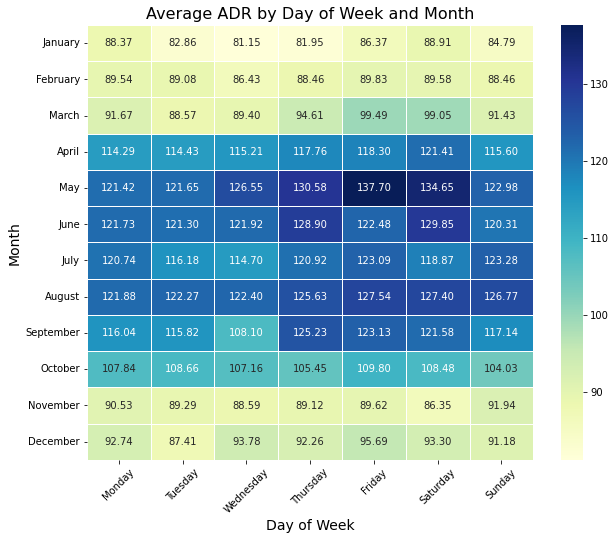

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creating a new column for the name of the month
hotel_data['month_name'] = hotel_data['arrival_date'].dt.month_name()

# Grouping by month name, day of the week, and calculating average ADR
adr_by_month_day = hotel_data.groupby(['month_name', 'day_of_week'])['adr'].mean().reset_index()

# Pivoting the data to create a 2D matrix of ADR
adr_pivot = adr_by_month_day.pivot(index='month_name', columns='day_of_week', values='adr').reindex(months_order)

# Sorting the days for better interpretation in the heatmap
adr_pivot = adr_pivot[days_order]

# Creating a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(adr_pivot, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)

plt.title('Average ADR by Day of Week and Month', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Month', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Display the heatmap
plt.show()


## Average adr by Room type

In [52]:
# Group by room type and calculate total revenue and total bookings for each type
adr_per_type = hotel_data.groupby('reserved_room_type').agg({
    'adr': 'sum',
    'reservation_status': 'count'
})

# Calculate average adr per room type
adr_per_type['average_adr'] = adr_per_type['adr'] / adr_per_type['reservation_status']

# Displaying the calculated average ADR per room type
adr_per_type['average_adr']


reserved_room_type
A     98.819755
B     90.467103
C     85.482143
D    132.216596
E    156.859048
F    187.724007
G    192.488121
P      0.000000
Name: average_adr, dtype: float64

In [53]:
# Grouping by month and room type, and calculating total revenue and total bookings for each group
adr_by_month_per_type = hotel_data.groupby(['arrival_date_month', 'reserved_room_type']).agg({
    'adr': 'sum',
    'reservation_status': 'count'
}).reset_index()

# Calculating average adr per room type per month
adr_by_month_per_type['average_adr'] = adr_by_month_per_type['adr'] / adr_by_month_per_type['reservation_status']

# Pivoting the data for better readability: months as rows and room types as columns
average_adr_by_month_per_type = adr_by_month_per_type.pivot(index='arrival_date_month', columns='reserved_room_type', values='average_adr')

# Sorting the months for better interpretation
average_adr_by_month_per_type = average_adr_by_month_per_type.reindex(months_order)

average_adr_by_month_per_type


reserved_room_type,A,B,C,D,E,F,G,P
arrival_date_month,,,,,,,,
January,78.983944,78.183014,NaN,102.049764,117.813594,152.750820,137.107500,NaN
February,80.306508,73.284815,NaN,106.840224,119.018191,160.397353,190.080690,NaN
March,84.458435,81.820526,NaN,110.777443,133.182409,175.825088,129.453333,NaN
April,103.055006,95.188642,NaN,134.065351,174.178198,194.537005,212.990476,0.0
May,113.803658,117.743333,56.000000,146.422534,170.184599,208.906235,205.072075,NaN
June,111.161202,116.367959,80.750000,144.156880,171.023451,202.801203,183.958409,NaN
July,104.462882,85.378382,NaN,143.104417,167.081223,195.060808,227.812162,NaN
August,108.156907,94.573580,104.000000,151.156422,176.054847,194.756461,221.119425,0.0
September,109.086439,107.365179,212.000000,139.773061,146.078333,199.368722,193.129394,NaN


In [54]:
# Extracting the day of the week from the arrival date
hotel_data['day_of_week'] = hotel_data['arrival_date'].dt.day_name()

# Grouping by day of week and room type and calculating the average ADR
average_adr_by_day_per_type = hotel_data.groupby(['day_of_week', 'reserved_room_type'])['adr'].mean().reset_index()

# Pivot the data for better readability
average_adr_by_day_per_type_pivot = average_adr_by_day_per_type.pivot(index='reserved_room_type', columns='day_of_week', values='adr')

average_adr_by_day_per_type_pivot.T

# Defining the order of days starting from Sunday
days_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Reordering the columns and transposing the data
average_adr_by_day_per_type_pivot = average_adr_by_day_per_type_pivot[days_order].T

average_adr_by_day_per_type_pivot



reserved_room_type,A,B,C,D,E,F,G,P
day_of_week,,,,,,,,
Sunday,99.632431,95.880993,NaN,129.444306,161.236491,179.804467,202.136792,NaN
Monday,99.968880,85.681484,117.000000,131.201812,148.049659,184.497261,191.686061,0.0
Tuesday,98.054028,86.897957,100.000000,129.703825,159.165330,191.343393,199.200377,0.0
Wednesday,96.360021,89.227983,100.500000,131.155392,144.689894,190.547577,179.418261,NaN
Thursday,99.193819,93.765610,43.333333,133.766772,161.076009,194.268789,189.580833,0.0
Friday,98.973699,91.865000,46.333333,134.265930,157.945905,186.582071,195.882913,0.0
Saturday,99.232203,87.721598,146.375000,134.808726,167.911500,187.115818,191.651429,NaN


# Occupancy Rate

## Average Daily Occupancy Rate by Room Type

In [55]:
# Calculating daily occupancy per room type
daily_occupancy_per_type = hotel_data.groupby(['arrival_date', 'reserved_room_type']).size().reset_index(name='booked_rooms')

# Merging with estimated total rooms per type
daily_occupancy_per_type = daily_occupancy_per_type.merge(estimated_rooms_per_type.reset_index().rename(columns={'index': 'reserved_room_type', 'reserved_room_type': 'total_rooms'}), on='reserved_room_type')

# Calculating daily occupancy rate per room type
daily_occupancy_per_type['daily_occupancy_rate'] = daily_occupancy_per_type['booked_rooms'] / daily_occupancy_per_type['total_rooms']

# Calculating average daily occupancy rate per room type
average_daily_occupancy_per_type = daily_occupancy_per_type.groupby('reserved_room_type')['daily_occupancy_rate'].mean()

average_daily_occupancy_per_type * 100  # converting to percentage for better readability


reserved_room_type
A    14.988912
B    34.513889
C          NaN
D    16.049622
E    23.467433
F    19.620324
G    38.258786
P          NaN
Name: daily_occupancy_rate, dtype: float64

In [56]:
# Extracting the month from the arrival date
hotel_data['arrival_month'] = hotel_data['arrival_date'].dt.strftime('%B')

# Calculating daily occupancy rate
hotel_data['daily_occupancy_rate'] = hotel_data['adults'] / estimated_total_rooms

# Calculating average occupancy rate by month
average_occupancy_by_month = hotel_data.groupby('arrival_month')['daily_occupancy_rate'].mean()

# Ordering by the calendar month for better readability
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
average_occupancy_by_month = average_occupancy_by_month.reindex(month_order)

average_occupancy_by_month * 100 *100  # converting to percentage for better readability


arrival_month
January      39.333812
February     40.786778
March        41.382827
April        43.098610
May          41.198846
June         42.085540
July         44.874780
August       44.706318
September    40.125592
October      40.160940
November     38.035048
December     42.258284
Name: daily_occupancy_rate, dtype: float64

In [57]:
# Calculating average occupancy rate by day of the week
average_occupancy_by_day = hotel_data.groupby('day_of_week')['daily_occupancy_rate'].mean()

# Ordering by the calendar day for better readability
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
average_occupancy_by_day = average_occupancy_by_day.reindex(day_order)

average_occupancy_by_day * 100 * 100  # converting to percentage for better readability


day_of_week
Sunday       42.451453
Monday       40.850871
Tuesday      40.064014
Wednesday    40.536803
Thursday     42.213238
Friday       43.181561
Saturday     43.783982
Name: daily_occupancy_rate, dtype: float64

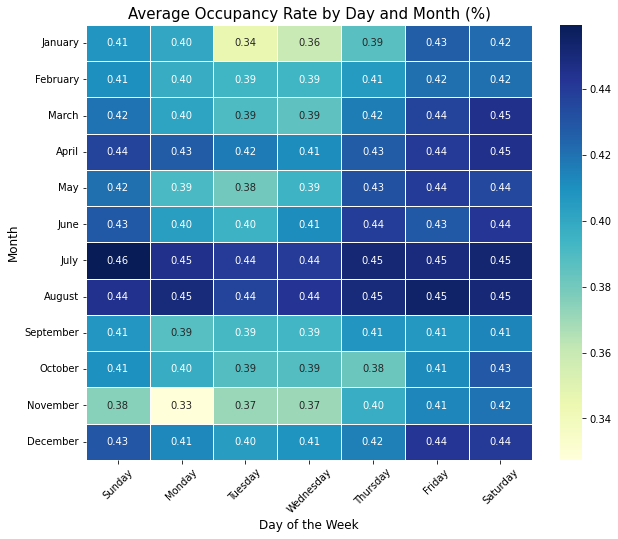

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Grouping by month and day of the week and calculating the average occupancy rate
average_occupancy_by_month_day = hotel_data.groupby(['arrival_month', 'day_of_week'])['daily_occupancy_rate'].mean().reset_index()

# Creating a pivot table suitable for a heatmap
heatmap_data = average_occupancy_by_month_day.pivot('arrival_month', 'day_of_week', 'daily_occupancy_rate')

# Ordering the data for better readability
heatmap_data = heatmap_data.reindex(month_order)[day_order]

# Creating the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data * 100, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)
plt.title('Average Occupancy Rate by Day and Month (%)', fontsize=15)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.xticks(rotation=45)
plt.show()


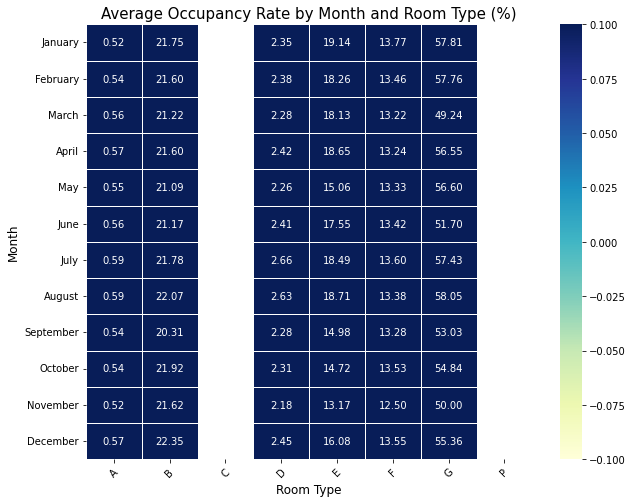

In [59]:
import pandas as pd

# Assuming hotel_data is the DataFrame containing the hotel booking data
# and estimated_rooms_per_type is the previously calculated estimate of total rooms per type

# Extracting the month from the arrival date
hotel_data['arrival_month'] = hotel_data['arrival_date'].dt.strftime('%B')

# Grouping by month and room type, and calculating total rooms booked and total bookings for each group
occupancy_by_month_per_type = hotel_data.groupby(['arrival_month', 'reserved_room_type']).agg({
    'adults': 'sum',  # Assuming 1 room per adult
    'reservation_status': 'count'  # Total number of bookings
}).reset_index()

# Merging with the previously calculated estimated_rooms_per_type to get the total rooms per type
# Also renaming the merged column to 'total_rooms'
occupancy_by_month_per_type = occupancy_by_month_per_type.merge(
    estimated_rooms_per_type.rename('total_rooms'), 
    left_on='reserved_room_type', 
    right_index=True
)

# Calculating average occupancy rate per room type per month
occupancy_by_month_per_type['average_occupancy_rate'] = (
    occupancy_by_month_per_type['adults'] / 
    (occupancy_by_month_per_type['total_rooms'] * occupancy_by_month_per_type['reservation_status'])
)

# Pivoting the data for better readability: months as rows and room types as columns
average_occupancy_by_month_per_type = occupancy_by_month_per_type.pivot(
    index='arrival_month', 
    columns='reserved_room_type', 
    values='average_occupancy_rate'
)

# Sorting the months for better interpretation
months_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
average_occupancy_by_month_per_type = average_occupancy_by_month_per_type.reindex(months_order)

# Converting to percentage for better readability
average_occupancy_by_month_per_type *= 100

# Creating the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(average_occupancy_by_month_per_type, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)
plt.title('Average Occupancy Rate by Month and Room Type (%)', fontsize=15)
plt.xlabel('Room Type', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.xticks(rotation=45)
plt.show()



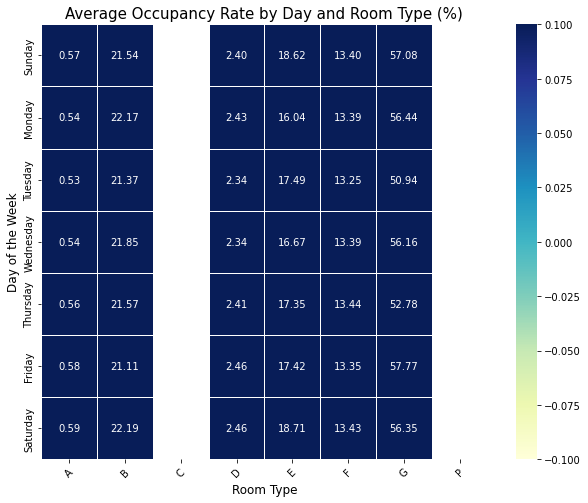

In [60]:
# Grouping by day of the week and room type, and calculating total rooms booked and total bookings for each group
occupancy_by_day_per_type = hotel_data.groupby(['day_of_week', 'reserved_room_type']).agg({
    'adults': 'sum',  # Assuming 1 room per adult
    'reservation_status': 'count'  # Total number of bookings
}).reset_index()

# Merging with the previously calculated estimated_rooms_per_type to get the total rooms per type
# Also renaming the merged column to 'total_rooms'
occupancy_by_day_per_type = occupancy_by_day_per_type.merge(
    estimated_rooms_per_type.rename('total_rooms'), 
    left_on='reserved_room_type', 
    right_index=True
)

# Calculating average occupancy rate per room type per day of the week
occupancy_by_day_per_type['average_occupancy_rate'] = (
    occupancy_by_day_per_type['adults'] / 
    (occupancy_by_day_per_type['total_rooms'] * occupancy_by_day_per_type['reservation_status'])
)

# Pivoting the data for better readability: days as rows and room types as columns
average_occupancy_by_day_per_type = occupancy_by_day_per_type.pivot(
    index='day_of_week', 
    columns='reserved_room_type', 
    values='average_occupancy_rate'
)

# Sorting the days for better interpretation
days_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
average_occupancy_by_day_per_type = average_occupancy_by_day_per_type.reindex(days_order)

# Converting to percentage for better readability
average_occupancy_by_day_per_type *= 100

# Creating the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(average_occupancy_by_day_per_type, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)
plt.title('Average Occupancy Rate by Day and Room Type (%)', fontsize=15)
plt.xlabel('Room Type', fontsize=12)
plt.ylabel('Day of the Week', fontsize=12)
plt.xticks(rotation=45)
plt.show()



# Cancellation Rate

In [61]:
# Extracting cancellation information
hotel_data['is_canceled'] = hotel_data['reservation_status'] == 'Canceled'

# Grouping by month and calculating the number of cancellations and total bookings for each group
cancellation_by_month = hotel_data.groupby('arrival_month').agg({
    'is_canceled': 'sum',  # Number of cancellations
    'reservation_status': 'count'  # Total bookings
}).reset_index()

# Calculating cancellation rate for each month
cancellation_by_month['cancellation_rate'] = (cancellation_by_month['is_canceled'] / 
                                             cancellation_by_month['reservation_status']) * 100

# Sorting the months for better interpretation
cancellation_by_month = cancellation_by_month.set_index('arrival_month').reindex(month_order).reset_index()

# Renaming the columns for better readability
cancellation_by_month.columns = ['Month', 'Number of Cancellations', 'Total Bookings', 'Average Cancellation Rate (%)']

cancellation_by_month


,Month,Number of Cancellations,Total Bookings,Average Cancellation Rate (%)
0,January,714,2730,26.153846
1,February,872,3604,24.195339
2,March,1281,4853,26.396044
3,April,1687,5076,33.234831
4,May,1674,5410,30.942699
5,June,1459,5002,29.168333
6,July,1825,5741,31.788887
7,August,2047,6588,31.071645
8,September,1015,4233,23.978266
9,October,1084,4206,25.772706


In [62]:
# Grouping by day of the week and calculating the number of cancellations and total bookings for each group
cancellation_by_day = hotel_data.groupby('day_of_week').agg({
    'is_canceled': 'sum',  # Number of cancellations
    'reservation_status': 'count'  # Total bookings
}).reset_index()

# Calculating cancellation rate for each day of the week
cancellation_by_day['cancellation_rate'] = (cancellation_by_day['is_canceled'] / 
                                           cancellation_by_day['reservation_status']) * 100

# Sorting the days for better interpretation
cancellation_by_day = cancellation_by_day.set_index('day_of_week').reindex(day_order).reset_index()

# Renaming the columns for better readability
cancellation_by_day.columns = ['Day of the Week', 'Number of Cancellations', 'Total Bookings', 'Average Cancellation Rate (%)']

cancellation_by_day


,Day of the Week,Number of Cancellations,Total Bookings,Average Cancellation Rate (%)
0,Sunday,1868,7134,26.184469
1,Monday,2338,8660,26.997691
2,Tuesday,1713,6677,25.655234
3,Wednesday,1953,7113,27.456769
4,Thursday,2456,7954,30.877546
5,Friday,2662,8508,31.288199
6,Saturday,2301,7353,31.293350


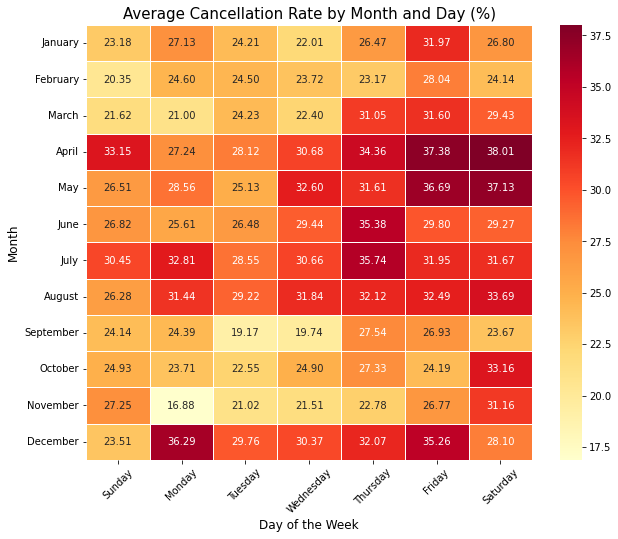

In [63]:
# Grouping by month and day of the week, and calculating the number of cancellations and total bookings for each group
cancellation_by_month_day = hotel_data.groupby(['arrival_month', 'day_of_week']).agg({
    'is_canceled': 'sum',  # Number of cancellations
    'reservation_status': 'count'  # Total bookings
}).reset_index()

# Calculating cancellation rate for each group
cancellation_by_month_day['cancellation_rate'] = (cancellation_by_month_day['is_canceled'] / 
                                                 cancellation_by_month_day['reservation_status']) * 100

# Creating a pivot table suitable for a heatmap
heatmap_data = cancellation_by_month_day.pivot('arrival_month', 'day_of_week', 'cancellation_rate')

# Ordering the data for better readability
heatmap_data = heatmap_data.reindex(month_order)[day_order]

# Creating the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap="YlOrRd", annot=True, fmt=".2f", linewidths=.5)
plt.title('Average Cancellation Rate by Month and Day (%)', fontsize=15)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.xticks(rotation=45)
plt.show()


In [64]:
# Grouping by room type and calculating the number of cancellations and total bookings for each group
cancellation_by_room_type = hotel_data.groupby('reserved_room_type').agg({
    'is_canceled': 'sum',  # Number of cancellations
    'reservation_status': 'count'  # Total bookings
}).reset_index()

# Calculating cancellation rate for each room type
cancellation_by_room_type['cancellation_rate'] = (cancellation_by_room_type['is_canceled'] / 
                                                 cancellation_by_room_type['reservation_status']) * 100

# Renaming the columns for better readability
cancellation_by_room_type.columns = ['Room Type', 'Number of Cancellations', 'Total Bookings', 'Average Cancellation Rate (%)']

cancellation_by_room_type


,Room Type,Number of Cancellations,Total Bookings,Average Cancellation Rate (%)
0,A,10244,37917,27.016905
1,B,304,994,30.583501
2,C,5,14,35.714286
3,D,3544,10764,32.924563
4,E,429,1470,29.183673
5,F,649,1757,36.937962
6,G,112,479,23.382046
7,P,4,4,100.000000


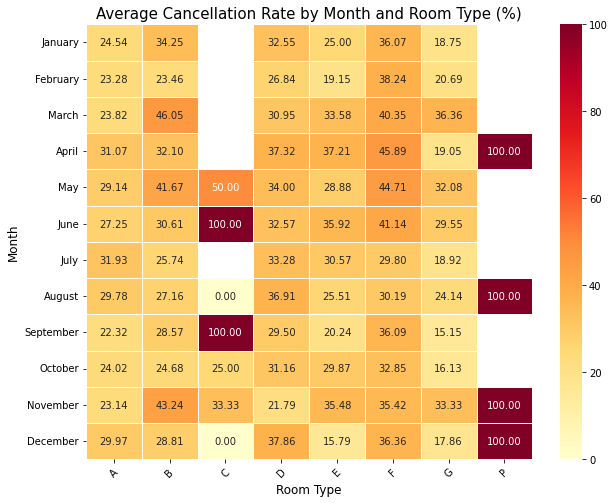

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming hotel_data is the DataFrame containing the hotel booking data
# and estimated_rooms_per_type is the previously calculated estimate of total rooms per type

# Extracting the month from the arrival date
hotel_data['arrival_month'] = hotel_data['arrival_date'].dt.strftime('%B')

# Grouping by month and room type, and calculating the number of cancellations and total bookings for each group
cancellation_by_month_per_type = hotel_data.groupby(['arrival_month', 'reserved_room_type']).agg({
    'is_canceled': 'sum',  # Number of cancellations
    'reservation_status': 'count'  # Total bookings
}).reset_index()

# Calculating cancellation rate for each group
cancellation_by_month_per_type['cancellation_rate'] = (
    cancellation_by_month_per_type['is_canceled'] / cancellation_by_month_per_type['reservation_status']
) * 100

# Pivoting the data for better readability: months as rows and room types as columns
average_cancellation_by_month_per_type = cancellation_by_month_per_type.pivot(
    index='arrival_month',
    columns='reserved_room_type',
    values='cancellation_rate'
)

# Sorting the months for better interpretation
months_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
average_cancellation_by_month_per_type = average_cancellation_by_month_per_type.reindex(months_order)

# Creating the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(average_cancellation_by_month_per_type, cmap="YlOrRd", annot=True, fmt=".2f", linewidths=.5)
plt.title('Average Cancellation Rate by Month and Room Type (%)', fontsize=15)
plt.xlabel('Room Type', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.xticks(rotation=45)
plt.show()



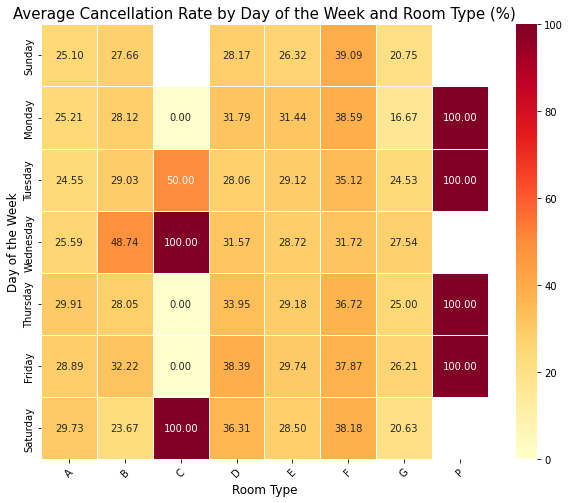

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming hotel_data is the DataFrame containing the hotel booking data
# and estimated_rooms_per_type is the previously calculated estimate of total rooms per type

# Grouping by day of the week and room type, and calculating the number of cancellations and total bookings for each group
cancellation_by_day_per_type = hotel_data.groupby(['day_of_week', 'reserved_room_type']).agg({
    'is_canceled': 'sum',  # Number of cancellations
    'reservation_status': 'count'  # Total bookings
}).reset_index()

# Calculating cancellation rate for each group
cancellation_by_day_per_type['cancellation_rate'] = (
    cancellation_by_day_per_type['is_canceled'] / cancellation_by_day_per_type['reservation_status']
) * 100

# Pivoting the data for better readability: days as rows and room types as columns
average_cancellation_by_day_per_type = cancellation_by_day_per_type.pivot(
    index='day_of_week',
    columns='reserved_room_type',
    values='cancellation_rate'
)

# Reordering the days of the week for better interpretation
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
average_cancellation_by_day_per_type = average_cancellation_by_day_per_type.reindex(day_order)

# Creating the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(average_cancellation_by_day_per_type, cmap="YlOrRd", annot=True, fmt=".2f", linewidths=.5)
plt.title('Average Cancellation Rate by Day of the Week and Room Type (%)', fontsize=15)
plt.xlabel('Room Type', fontsize=12)
plt.ylabel('Day of the Week', fontsize=12)
plt.xticks(rotation=45)
plt.show()
